In [2]:
!pip install tensorflow

In [33]:
import tensorflow as tf
tf.version.VERSION

'2.10.1'

In [34]:
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

In [35]:
emotion_df = pd.read_csv('emotion.csv')

In [36]:
emotion_df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...,...,...
24563,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564,0,181 177 176 156 178 144 136 132 122 107 131 16...
24565,3,178 174 172 173 181 188 191 194 196 199 200 20...
24566,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


In [37]:
emotion_df['pixels'] = emotion_df[' pixels'] 

In [38]:
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [39]:
emotion_df['pixels'] = emotion_df['pixels'].apply(lambda x: string2array(x))

In [40]:
emotion_df.isnull().sum()

emotion    0
 pixels    0
pixels     0
dtype: int64

In [41]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

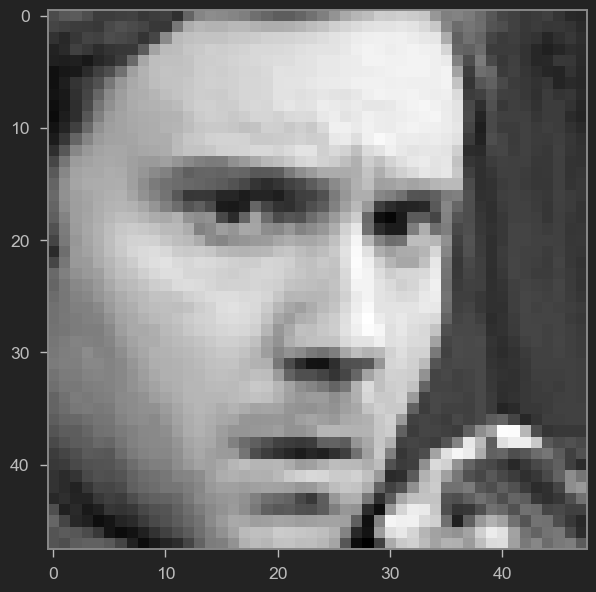

In [42]:
plt.imshow(emotion_df['pixels'][0].squeeze(),cmap='gray')

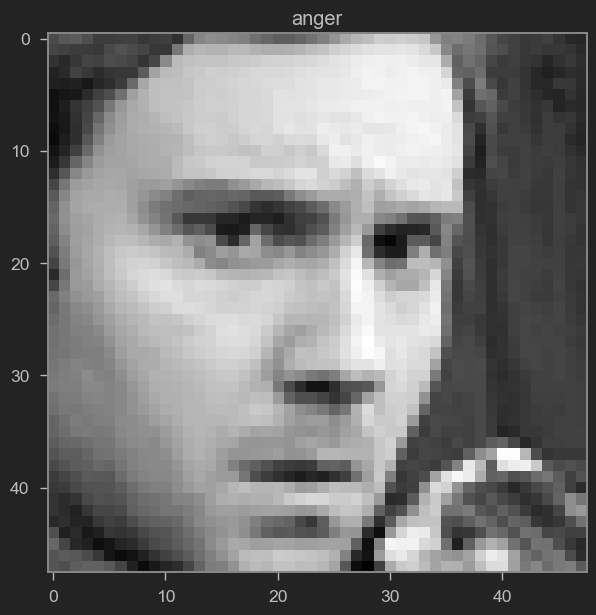

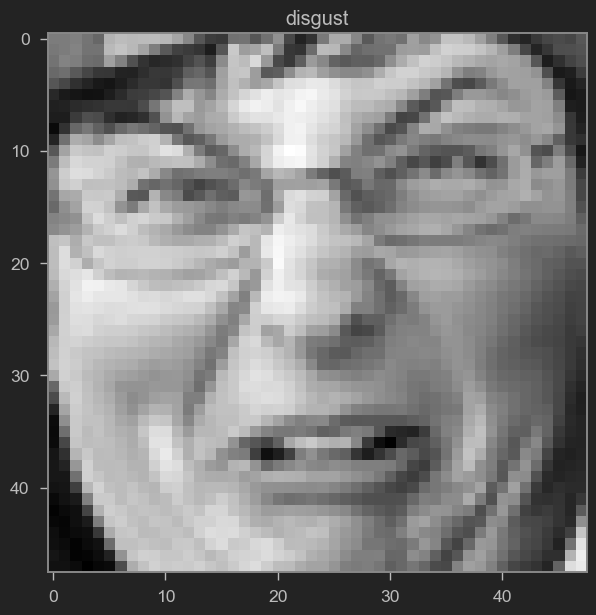

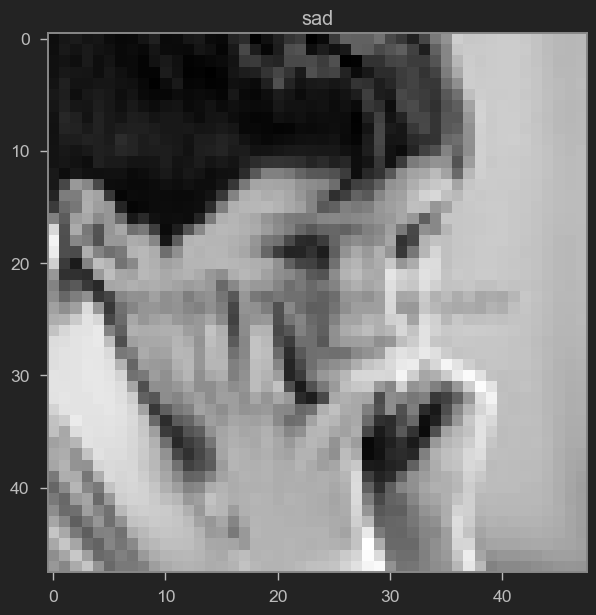

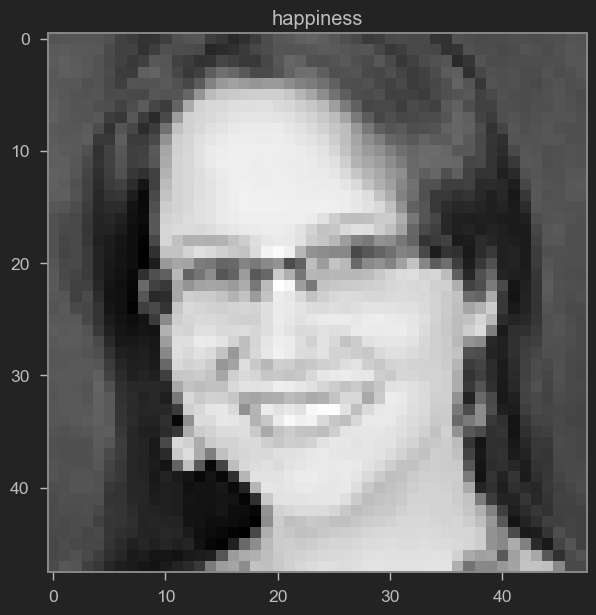

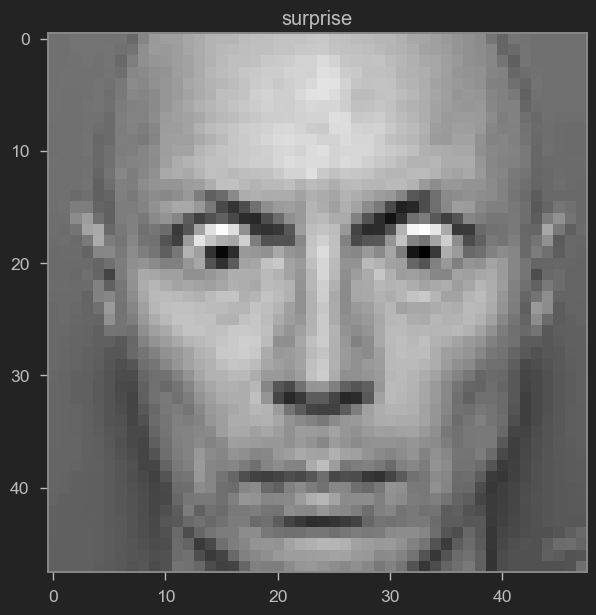

In [43]:
emotions = [0,1,2,3,4]

for i in emotions:
  data = emotion_df[emotion_df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(48,48)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap= 'gray')

Text(0.5, 1.0, 'No. of images per emotion')

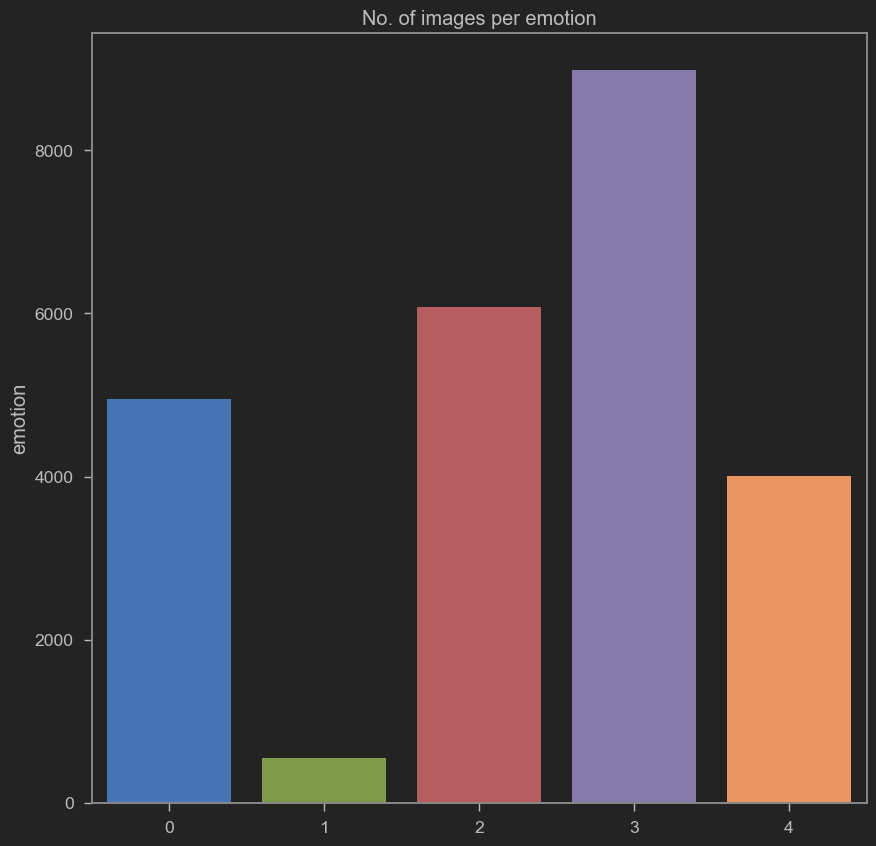

In [44]:
plt.figure(figsize=(10,10))
sns.barplot(x=emotion_df.emotion.value_counts().index, y= emotion_df.emotion.value_counts())
plt.title('No. of images per emotion')

In [45]:
X = emotion_df['pixels']
X.shape

(24568,)

In [46]:
# split the dataframe to features and labels
# from keras.utils import to_categorical

X = emotion_df['pixels']
# y = to_categorical(emotion_df['emotion'])
y = pd.get_dummies(emotion_df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(24568, 48, 48, 1)

print(X.shape, y.shape)

(24568, 48, 48, 1) (24568, 5)


In [47]:
X = np.array(X)
y = np.array(y)

In [48]:
# spliting the dataframe in to train,test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X,y,test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)


In [49]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [86]:
train_datagen = ImageDataGenerator(
    #rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode = "nearest",
    #brightness_range=(0.2,0.8)
)


In [87]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [88]:
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['zero_padding2d_6[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']           

 res_2_identity_2_b (Conv2D)    (None, 5, 5, 64)     36928       ['activation_121[0][0]']         
                                                                                                  
 bn_2_identity_2_b (BatchNormal  (None, 5, 5, 64)    256         ['res_2_identity_2_b[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_122 (Activation)    (None, 5, 5, 64)     0           ['bn_2_identity_2_b[0][0]']      
                                                                                                  
 res_2_identity_2_c (Conv2D)    (None, 5, 5, 256)    16640       ['activation_122[0][0]']         
                                                                                                  
 bn_2_identity_2_c (BatchNormal  (None, 5, 5, 256)   1024        ['res_2_identity_2_c[0][0]']     
 ization) 

 res_3_identity_2_b (Conv2D)    (None, 2, 2, 128)    147584      ['activation_130[0][0]']         
                                                                                                  
 bn_3_identity_2_b (BatchNormal  (None, 2, 2, 128)   512         ['res_3_identity_2_b[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_131 (Activation)    (None, 2, 2, 128)    0           ['bn_3_identity_2_b[0][0]']      
                                                                                                  
 res_3_identity_2_c (Conv2D)    (None, 2, 2, 512)    66048       ['activation_131[0][0]']         
                                                                                                  
 bn_3_identity_2_c (BatchNormal  (None, 2, 2, 512)   2048        ['res_3_identity_2_c[0][0]']     
 ization) 

In [112]:
# train the network

model_emotion.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [113]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [114]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 10, callbacks=[checkpointer, earlystopping])

Epoch 1/10
345/345 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.7778
Epoch 1: val_loss improved from inf to 0.66944, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 48s 135ms/step - loss: 0.5776 - accuracy: 0.7778 - val_loss: 0.6694 - val_accuracy: 0.7500
Epoch 2/10
345/345 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7877
Epoch 2: val_loss improved from 0.66944 to 0.66678, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 46s 134ms/step - loss: 0.5567 - accuracy: 0.7877 - val_loss: 0.6668 - val_accuracy: 0.7549
Epoch 3/10
345/345 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7929
Epoch 3: val_loss did not improve from 0.66678
345/345 [==============================] - 46s 134ms/step - loss: 0.5459 - accuracy: 0.7929 - val_loss: 0.6752 - val_accuracy: 0.7459
Epoch 4/10
345/345 [==============================] - ETA: 0s - loss: 0

In [115]:
# saving the model architecture to json file for future use

model_json = model_emotion.to_json()
with open("Emotion-model.json","w") as json_file:
  json_file.write(model_json)

In [116]:
with open('Emotion-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_emotion = tf.keras.models.model_from_json(json_savedModel)
model_emotion.load_weights('FacialExpression_weights.hdf5')
model_emotion.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [117]:
score = model_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 1s 19ms/step - loss: 0.6968 - accuracy: 0.7494
Test Accuracy: 0.7493897676467896


In [118]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [119]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

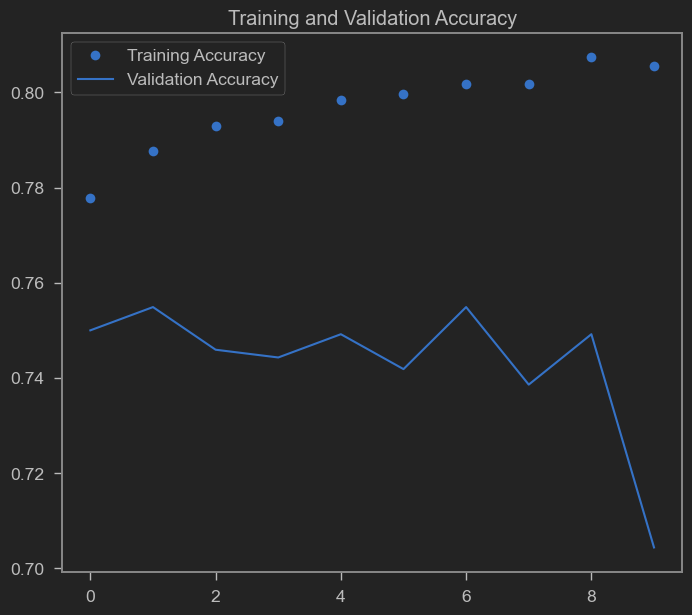

In [120]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

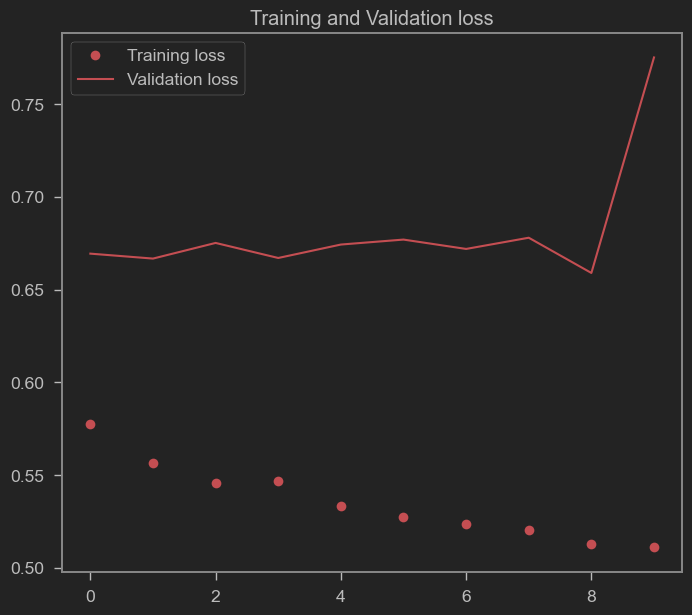

In [121]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [122]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 [==============================] - 1s 19ms/step


In [123]:
y_true.shape

(1229,)

<AxesSubplot: >

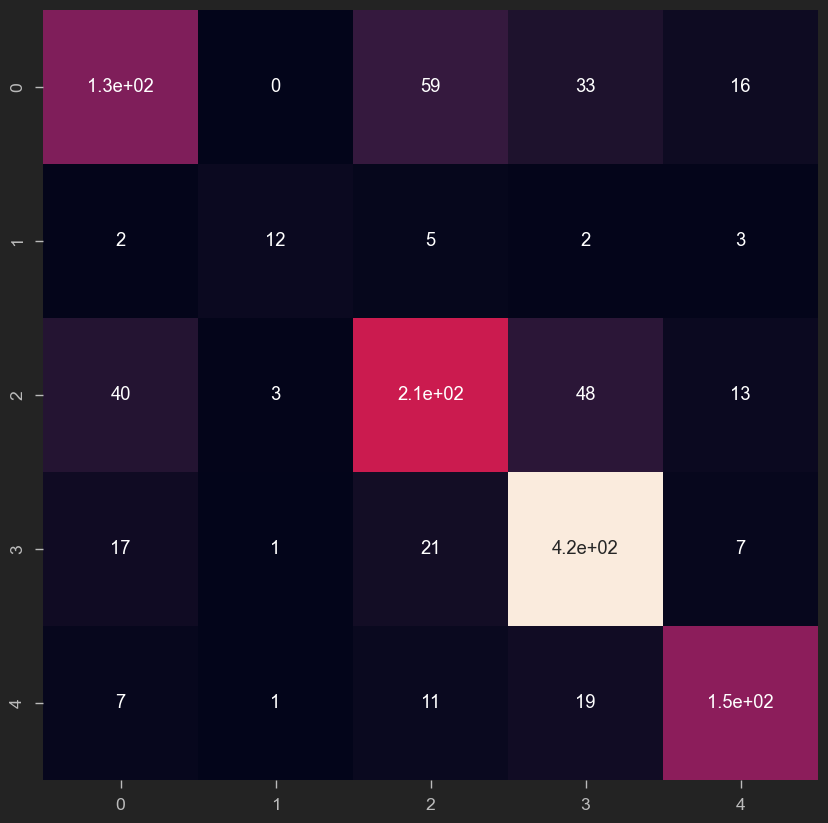

In [124]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

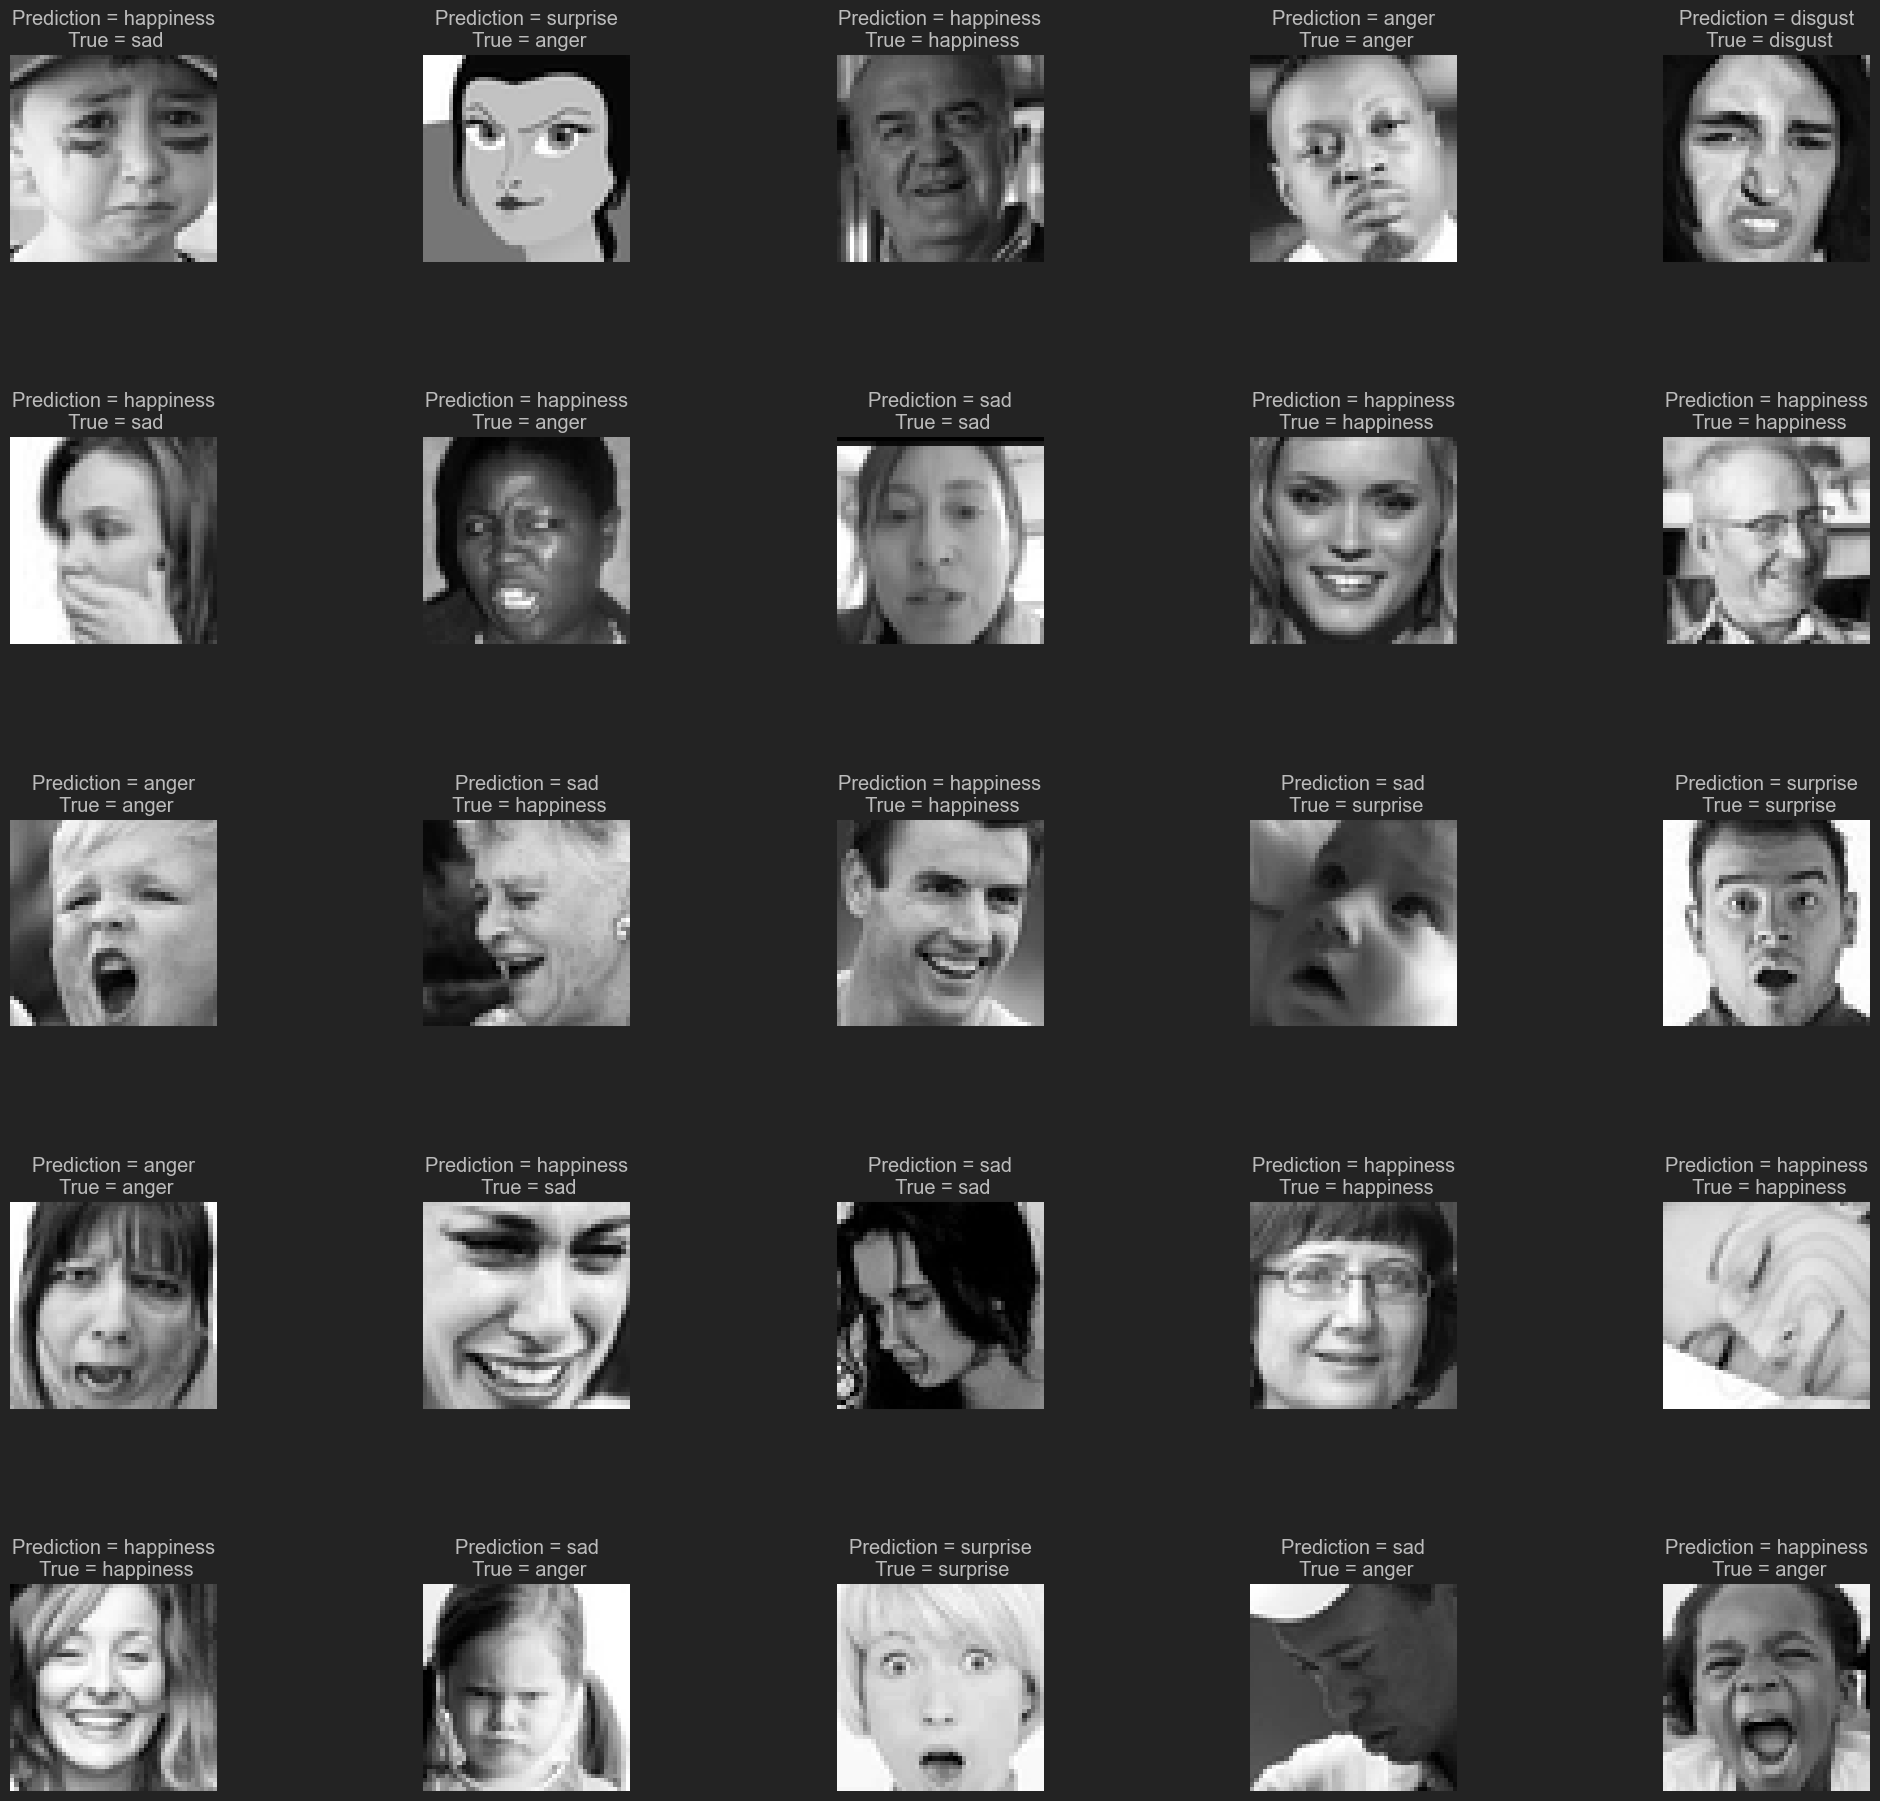

In [126]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_Test[i].reshape(48,48), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.67      0.55      0.61       242
           1       0.71      0.50      0.59        24
           2       0.69      0.67      0.68       313
           3       0.80      0.90      0.85       464
           4       0.79      0.80      0.79       186

    accuracy                           0.75      1229
   macro avg       0.73      0.68      0.70      1229
weighted avg       0.74      0.75      0.74      1229

